In [ ]:
#Import libraries

from google.colab import files  
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
from google.colab import drive 
from google.colab.patches import cv2_imshow

from io import BytesIO
import numpy as np
import pandas as pd
import sys, os, re, csv, codecs
from os import listdir
import cv2

import tensorflow as tf
import keras
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras import models
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Dense, Input, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.data_utils import get_file
from keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import skimage
import scipy
from scipy import ndimage, misc
from PIL import Image
import glob
import sklearn
from sklearn.metrics import confusion_matrix
import imutils
from imblearn.under_sampling import NearMiss

AUTHENTICATION

In [ ]:
### FIRST THING FIRST COMES AUTHENTICATION
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# DATASET UPLOAD

In [ ]:
#Dataset uploading
fileId = drive.CreateFile({'id': '1lx4ortYvnjQ_TR2zHatPRo8psDnU6E0z'}) 
fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(fileId['title'], fileId['id']))

Uploaded dataset_DogCat.zip, id 1lx4ortYvnjQ_TR2zHatPRo8psDnU6E0z


In [ ]:
#Dataset unzipping
!unzip -q dataset_DogCat.zip 
print('dataset unzipped') 

replace dataset_DogCat/testing/cat/images (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
dataset unzipped


# FUNCTIONS FOR DATA AUGMENTATION AND PREPROCESSING

In [ ]:
 #Function for data augmentation
 # read_path = path to the folder with images to be augmented
 def data_augmentation(read_path):
  for files in os.listdir(read_path):
    img_to_augment = cv2.imread(read_path + files)  #reading the image
    horizontal_img = cv2.flip(img_to_augment, 0)#applying flipping augmentation  
    rot_img90_ = cv2.rotate(img_to_augment, cv2.ROTATE_90_COUNTERCLOCKWISE)
    root, ext = os.path.splitext(files)  
    cv2.imwrite(os.path.join(read_path, root + '_flipO' + ext), horizontal_img)
    cv2.imwrite(os.path.join(read_path, root + 'rot_90' + ext), rot_img90_)

In [ ]:
#Function for OFFLINE (i.e., not during training) data preprocessing
# read_path = path to the folder with images to be preprocessed 
# imgs_array = empty tensor to fill with preprocessed images
# label_array = array to be fill with lables
# idlabel = label [0/1]
def input_to_CNN(read_path, imgs_array, label_array, idlabel):
  for index, filename in enumerate(os.listdir(read_path)):
    index = index + 1
    imgs = load_img(os.path.join(read_path,filename), target_size=(224,224))  
    imgs = img_to_array(imgs)
    imgs = imgs.reshape((1, imgs.shape[0], imgs.shape[1], imgs.shape[2]))
    imgs = preprocess_input(imgs) #as required by the original training of VGG16 
    imgs_array[index,:,:,:] = imgs
    label_array.append(idlabel)

In [ ]:
cd dataset_DogCat/

/content/dataset_DogCat


In [ ]:
ls

cat/  dataset_DogCat/  dataset_DogCat.zip  dog/


In [ ]:
cd training/

/content/dataset_DogCat/training


#TRAINING PREPARATION

In [ ]:
read_path_dogs = "/content/dataset_DogCat/training/dog/"   #path to read training images for both the two classes 
read_path_cats = "/content/dataset_DogCat/training/cat/"

img_rows = 224
img_cols = 224

print("dog images before data augmentation: ", len(os.listdir(read_path_dogs)))   
print("cat images before data augmentation: ", len(os.listdir(read_path_cats)))

#Data augmentation for both classes
data_augmentation(read_path_dogs)
data_augmentation(read_path_cats)

#Total number of training images
filename_dog = os.listdir(read_path_dogs)
count_dogs = len(filename_dog) 
print("DOG images after data augmentation: ", count_dogs) 
filename_cat = os.listdir(read_path_cats)
count_cats= len(filename_cat)
print("CAT images after data augmentation: ", count_cats) 

total_samples = count_dogs + count_cats
print("Training images: ", total_samples)

#Preparing training tensor and label array
imgs_array_train = np.ones((total_samples, img_rows, img_cols, 3)) # [batch of training, height, width, channels (RGB)]
print("Train tensor shape ", imgs_array_train.shape)
label_array_train = []

dog images before data augmentation:  30
cat images before data augmentation:  30
DOG images after data augmentation:  90
CAT images after data augmentation:  90
Training images:  180
Train tensor shape  (180, 224, 224, 3)


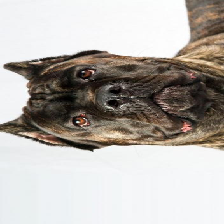

In [ ]:
sample_image = load_img(os.path.join(read_path_dogs,filename_dog[10]), target_size=(224,224))
sample_image

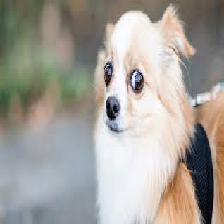

In [ ]:
samples_image1 = load_img(os.path.join(read_path_dogs,filename_dog[35]), target_size=(224,224))
samples_image1

In [ ]:
input_to_CNN(read_path_dogs, imgs_array_train, label_array_train, 1) #label 1 for class dog
input_to_CNN(read_path_cats, imgs_array_train, label_array_train, 0) #label 0 for class cat

In [ ]:
imgs_array_train.shape

(180, 224, 224, 3)

In [ ]:
from collections import Counter
Counter(label_array_train)

Counter({0: 90, 1: 90})

#VALIDATION PREPARATION

In [ ]:
read_path_dogs = "/content/dataset_DogCat/validation/dog/"   #path to read training images for both the two classes 
read_path_cats = "/content/dataset_DogCat/validation/cat/"

img_rows = 224
img_cols = 224

#NO DATA AUGMENTATION

#Total number of valid images
filename_dog = os.listdir(read_path_dogs)
count_dogs = len(filename_dog) 
print("DOG images in validation: ", count_dogs) 
filename_cat = os.listdir(read_path_cats)
count_cats= len(filename_cat)
print("CAT images in validation: ", count_cats) 

total_samples = count_dogs + count_cats
print("valid images: ", total_samples)

#Preparing training tensor and label array
imgs_array_valid = np.ones((total_samples, img_rows, img_cols, 3)) # [batch of valid, height, width, channels (RGB)]
print("Train tensor shape ", imgs_array_valid.shape)
label_array_valid = []

DOG images in validation:  10
CAT images in validation:  10
valid images:  20
Train tensor shape  (20, 224, 224, 3)


In [ ]:
input_to_CNN(read_path_dogs,imgs_array_valid,label_array_valid, 1)
input_to_CNN(read_path_cats,imgs_array_valid,label_array_valid, 0)

In [ ]:
imgs_array_valid.shape

(20, 224, 224, 3)

In [ ]:
Counter(label_array_valid)

Counter({0: 10, 1: 10})

#TESTING PREPARATION

In [ ]:
read_path_dogs = "/content/dataset_DogCat/testing/dog/"   #path to read training images for both the two classes 
read_path_cats = "/content/dataset_DogCat/testing/cat/"

img_rows = 224
img_cols = 224

#NO DATA AUGMENTATION

#Total number of valid images
filename_dog = os.listdir(read_path_dogs)
count_dogs = len(filename_dog) 
print("DOG images in testing: ", count_dogs) 
filename_cat = os.listdir(read_path_cats)
count_cats= len(filename_cat)
print("CAT images in testing: ", count_cats) 

total_samples = count_dogs + count_cats
print("test images: ", total_samples)

#Preparing training tensor and label array
imgs_array_test= np.ones((total_samples, img_rows, img_cols, 3)) # [batch of valid, height, width, channels (RGB)]
print("Train tensor shape ", imgs_array_test.shape)
label_array_test = []

DOG images in testing:  10
CAT images in testing:  10
test images:  20
Train tensor shape  (20, 224, 224, 3)


In [ ]:
input_to_CNN(read_path_dogs,imgs_array_test,label_array_test,1)
input_to_CNN(read_path_cats,imgs_array_test,label_array_test,0)

In [ ]:
print(len(label_array_test))
print(len(imgs_array_test))

20
20


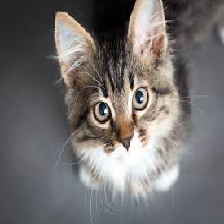

In [ ]:
filename_cat = os.listdir(read_path_cats)

sample_image = load_img(os.path.join(read_path_cats,filename_cat[1]), target_size=(224,224))
sample_image

#FINE TUNING VGG16

In [ ]:
X = imgs_array_train
y = label_array_train
y = to_categorical(y, num_classes = 2)

X_val = imgs_array_valid
y_val = label_array_valid
y_val = to_categorical(y_val, num_classes = 2)

![alt text](https://drive.google.com/uc?id=1eBs6rmbUFWY7btv-mHs6AS_CAVIEvpuy)


In [ ]:
#Take the convolutional layers of VGG16 and freeze the first layers
vgg_conv = VGG16(include_top = False, weights ='imagenet', input_shape=(img_rows, img_cols, 3)) #excluding the TOP (i.e., the fully connected layers) because we want to redefine it
vgg_conv.summary()

# Freeze the all VGG16 layers except the last 4 CONV layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False  

for layer in vgg_conv.layers:       
    print(layer, layer.trainable)

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
#Build a new model using the convolutional layers of VGG16 with (on top) some dense layers

model_tune = models.Sequential()
 
# Add the vgg convolutional base model
model_tune.add(vgg_conv)
 
# Add new layers (by default, kernel_initializer = 'glorot_uniform')
model_tune.add(layers.Flatten())
model_tune.add(layers.Dense(1024, activation='relu'))
model_tune.add(layers.Dense(512, activation='relu'))
model_tune.add(layers.Dense(512, activation='tanh'))
model_tune.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model_tune.summary()
model_tune.compile(loss="binary_crossentropy", optimizer="Adam" ,metrics=["accuracy"]) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 41,194,306
Trainable params: 33,559,042
No

In [ ]:
#Perform fine tuning using the training set (validation during fine tuning is performed on the validation set)
history = model_tune.fit(x=X, y=y, epochs=30, verbose=1, validation_data = (X_val, y_val), shuffle=True)

Epoch 1/30
6/6 [==============================] - 28s 2s/step - loss: 0.3153 - accuracy: 0.7833 - val_loss: 0.6950 - val_accuracy: 0.9000
Epoch 2/30
6/6 [==============================] - 2s 314ms/step - loss: 0.0880 - accuracy: 0.9889 - val_loss: 0.4934 - val_accuracy: 0.9000
Epoch 3/30
6/6 [==============================] - 2s 314ms/step - loss: 0.1131 - accuracy: 0.9889 - val_loss: 0.4463 - val_accuracy: 0.9000
Epoch 4/30
6/6 [==============================] - 2s 314ms/step - loss: 0.1416 - accuracy: 0.9889 - val_loss: 0.3713 - val_accuracy: 0.9000
Epoch 5/30
6/6 [==============================] - 2s 311ms/step - loss: 0.1615 - accuracy: 0.9889 - val_loss: 0.3940 - val_accuracy: 0.9000
Epoch 6/30
6/6 [==============================] - 2s 313ms/step - loss: 0.2146 - accuracy: 0.9889 - val_loss: 0.3367 - val_accuracy: 0.9000
Epoch 7/30
6/6 [==============================] - 2s 314ms/step - loss: 0.2203 - accuracy: 0.9889 - val_loss: 0.3667 - val_accuracy: 0.9000
Epoch 8/30
6/6 [======

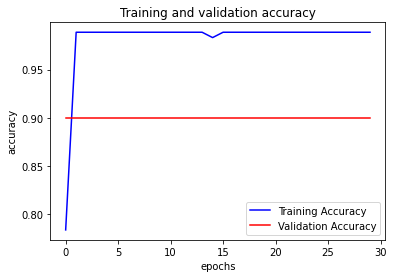

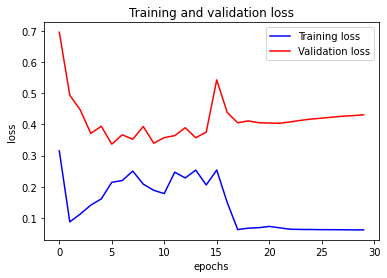

In [ ]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accu))
plt.plot(epochs, accu, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.legend()
plt.figure() 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() 
plt.show()

#SAVING MODEL AND WEIGHTS

In [ ]:
!mkdir '/content/MODEL-WEIGHTS-FINETUNING' 

In [ ]:
cd /content/

/content


In [ ]:
ls

adc.json         dataset_DogCat.zip         sample_data/
dataset_DogCat/  MODEL-WEIGHTS-FINETUNING/


In [ ]:
model_json_tuned = model_tune.to_json()
with open("/content/MODEL-WEIGHTS-FINETUNING/model_tuned.json", "w") as json_file:
    json_file.write(model_json_tuned)
model_tune.save_weights("/content/MODEL-WEIGHTS-FINETUNING/model_tuned.h5")
print("Model and weights saved")

Model and weights saved


#PREDICTION

In [ ]:
X_test = imgs_array_test
y_test = label_array_test

1) Prediction on the same Colab session

In [ ]:
y_predicted = model_tune.predict(X_test)
pred_class = np.argmax(y_predicted, axis = 1)
print(pred_class)   
print(sklearn.metrics.classification_report(y_test, pred_class))

[0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.90      0.90      0.90        10

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20

